## LSTM Model 2 - class weights, LSTM Model 3 - class weights and early stopping

The code was adapted from a blog post by Aishwarya Singh (2019) called 'A Hands-On Introduction to Time Series Classification (with Python Code)'

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.preprocessing import sequence
from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

# fix random seed for reproducibility
np.random.seed(7)

Using TensorFlow backend.


In [2]:
# Load data 
df = pd.read_csv('Seq_data_2.csv')

In [3]:
df.shape

(216563, 77)

In [4]:
# Load targets
targets = pd.read_csv('Seq_target.csv')

In [5]:
targets.shape

(11976, 1)

In [6]:
# Set sequence length
seq_len = 9

In [7]:
# Generate the sequences using Patient IDs
sequences = list()
patient_list = df['BrcId'].unique()
for patient in patient_list:
    values = df[df['BrcId']==patient].values
    sequences.append(values)

In [8]:
# Show the sequence stats
len_sequences = []
for one_seq in sequences:
    len_sequences.append(len(one_seq))
pd.Series(len_sequences).describe()

count    11976.000000
mean        18.083083
std         25.519482
min          2.000000
25%          6.000000
50%          9.000000
75%         19.000000
max        687.000000
dtype: float64

In [9]:
#truncate the sequence to length 9, pad values with -1
sequences=sequence.pad_sequences(sequences, maxlen=seq_len, padding='pre', dtype='float', truncating='pre', value=-1)

In [10]:
# Updated length is now 9 for all sequences
len_sequences = []
for one_seq in sequences:
    len_sequences.append(len(one_seq))
pd.Series(len_sequences).describe()

count    11976.0
mean         9.0
std          0.0
min          9.0
25%          9.0
50%          9.0
75%          9.0
max          9.0
dtype: float64

In [11]:
# Set the sequence data to df and targets to the target field
df = sequences
targets = np.array(targets['relapse_in_24M'])

In [12]:
# Split training and testing - 70/30
num_train_patients = round(.7*targets.shape[0])
num_test_patients = round(.3*targets.shape[0])

In [13]:
# Assign training and testing to index ranges
X_train = [df[i] for i in range(num_train_patients)] 
X_test = [df[i+num_train_patients] for i in range(num_test_patients)]
y_train = [targets[i] for i in range(num_train_patients)] 
y_test = [targets[i+num_train_patients] for i in range(num_test_patients)] 

In [14]:
# Convert to numpy arrays
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [15]:
X_train.shape

(8383, 9, 77)

In [16]:
# Remove BrcID
X_train= np.delete(X_train,0,axis=2)
X_test = np.delete(X_test,0,axis=2)

In [17]:
X_train.shape

(8383, 9, 76)

### Grid Search

This code was adapted from a blog post by Jason Brownlee (2019) called 'How to Grid Search Hyperparameters for Deep Learning Models in Python With Keras'.

In [47]:
# Use scikit-learn to grid search the batch size and epochs
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

# Function to create model, required for KerasClassifier
def create_model():
    model = Sequential()
    model.add(LSTM(100, input_shape=(seq_len, X_train.shape[2])))
    model.add(Dense(1, activation='sigmoid'))

    # Loss function is binary_crossentropy as it's binary classification, ADAM optimization algorithm
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# create model
model = KerasClassifier(build_fn=create_model, verbose=0)

# define the grid search parameters
batch_size = [10, 20, 30]
epochs = [10, 20, 50, 100]

param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid)
class_weight = {1:8.17, 0:1}
grid_result = grid.fit(X_train, y_train, class_weight=class_weight)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

C:\Users\LDwyer\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Best: 0.784325 using {'batch_size': 30, 'epochs': 100}
0.562090 (0.098161) with: {'batch_size': 10, 'epochs': 10}
0.655851 (0.025078) with: {'batch_size': 10, 'epochs': 20}
0.760706 (0.020924) with: {'batch_size': 10, 'epochs': 50}
0.783729 (0.013532) with: {'batch_size': 10, 'epochs': 100}
0.515448 (0.027140) with: {'batch_size': 20, 'epochs': 10}
0.645950 (0.033894) with: {'batch_size': 20, 'epochs': 20}
0.765836 (0.011505) with: {'batch_size': 20, 'epochs': 50}
0.761422 (0.041391) with: {'batch_size': 20, 'epochs': 100}
0.560420 (0.032305) with: {'batch_size': 30, 'epochs': 10}
0.654539 (0.029225) with: {'batch_size': 30, 'epochs': 20}
0.760229 (0.009227) with: {'batch_size': 30, 'epochs': 50}
0.784325 (0.011197) with: {'batch_size': 30, 'epochs': 100}


In [48]:
# Use scikit-learn to grid search the number of hidden units
# Function to create model, required for KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

def create_model(units=50):
    model = Sequential()
    model.add(LSTM(units, input_shape=(seq_len, X_train.shape[2])))
    model.add(Dense(1, activation='sigmoid'))

    # Loss function is binary_crossentropy as it's binary classification, ADAM optimization algorithm
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# create model
model = KerasClassifier(build_fn=create_model, verbose=0, epochs=100, batch_size=30)

# define the grid search parameters
units = [50, 100, 150, 200, 250, 300]

param_grid = dict(units=units)
grid = GridSearchCV(estimator=model, param_grid=param_grid)
class_weight = {1:8.17, 0:1}
grid_result = grid.fit(X_train, y_train, class_weight=class_weight)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.794823 using {'units': 300}
0.767267 (0.012275) with: {'units': 50}
0.790171 (0.007498) with: {'units': 100}
0.788381 (0.004072) with: {'units': 150}
0.749135 (0.063298) with: {'units': 200}
0.777884 (0.028214) with: {'units': 250}
0.794823 (0.005115) with: {'units': 300}


### Build Model 2 with best hyperparameters from Grid Search

In [18]:
# Create model with LSTM layer
model = Sequential()
model.add(LSTM(300, input_shape=(seq_len, X_train.shape[2])))
model.add(Dense(1, activation='sigmoid'))

# Loss function is binary_crossentropy as it's binary classification, efficient ADAM optimization algorithm used
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


In [19]:
# Model summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 300)               452400    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 301       
Total params: 452,701
Trainable params: 452,701
Non-trainable params: 0
_________________________________________________________________


In [20]:
# Fit model  
class_weight = {1:8.17, 0:1}
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=30
                    ,  class_weight = class_weight)

Instructions for updating:
Use tf.cast instead.
Train on 8383 samples, validate on 3593 samples
Epoch 1/100
8383/8383 [==============================] - 12s 1ms/step - loss: 1.3128 - acc: 0.4217 - val_loss: 0.7122 - val_acc: 0.5096
Epoch 2/100
8383/8383 [==============================] - 10s 1ms/step - loss: 1.2884 - acc: 0.4609 - val_loss: 0.8140 - val_acc: 0.3743
Epoch 3/100
8383/8383 [==============================] - 9s 1ms/step - loss: 1.2804 - acc: 0.4639 - val_loss: 0.7474 - val_acc: 0.5129
Epoch 4/100
8383/8383 [==============================] - 9s 1ms/step - loss: 1.2694 - acc: 0.4941 - val_loss: 0.8066 - val_acc: 0.3919
Epoch 5/100
8383/8383 [==============================] - 9s 1ms/step - loss: 1.2630 - acc: 0.4891 - val_loss: 0.7300 - val_acc: 0.5032
Epoch 6/100
8383/8383 [==============================] - 10s 1ms/step - loss: 1.2605 - acc: 0.5002 - val_loss: 0.7027 - val_acc: 0.5436
Epoch 7/100
8383/8383 [==============================] - 8s 977us/step - loss: 1.2434 - acc

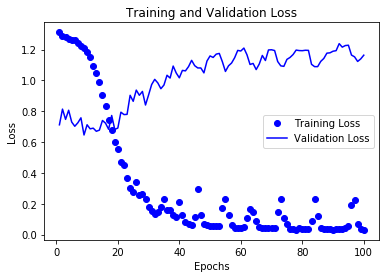

In [29]:
# Plot training and validation loss 
# Code provided by Chollet (2018, p. 74)

import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'bo', label='Training Loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

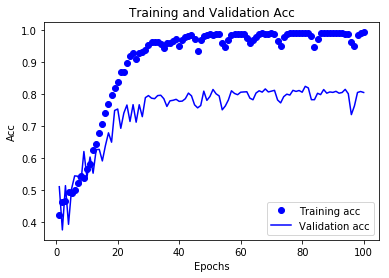

In [30]:
# Plot training and validation accuracy 
# Code provided by Chollet (2018, p. 75)

plt.clf()
acc = history_dict['acc']
val_acc = history_dict['val_acc']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation Acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [24]:
# Predict classes for test set
# Code provided by Jason Brownlee (2019) in 'How to Calculate Precision, Recall, F1, and More for Deep Learning Models’

yhat_classes = model.predict_classes(X_test)

In [25]:
# Calculate additional metrics 
# Code provided by Jason Brownlee (2019) in 'How to Calculate Precision, Recall, F1, and More for Deep Learning Models’

from sklearn import metrics
accuracy = metrics.accuracy_score(y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = metrics.precision_score(y_test, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = metrics.recall_score(y_test, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = metrics.f1_score(y_test, yhat_classes)
print('F1 score: %f' % f1)

Accuracy: 0.804620
Precision: 0.133489
Recall: 0.146530
F1 score: 0.139706


In [26]:
# Confusion matrix
# Code provided by Scikit-learn API Reference (2019) 

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, yhat_classes)

array([[2834,  370],
       [ 332,   57]], dtype=int64)

In [27]:
# Code provided by Scikit-learn API Reference (2019) 

tn, fp, fn, tp = confusion_matrix(y_test, yhat_classes).ravel()
tn, fp, fn, tp

(2834, 370, 332, 57)

In [28]:
# AUC
# Code provided by Scikit-learn API Reference (2019) 

fpr, tpr, thresholds = metrics.roc_curve(y_test, yhat_classes, pos_label=1)
metrics.auc(fpr, tpr)

0.5155244568967454

### Create Model 3 with Early Stopping to stop overfitting 

In [46]:
# Create model with LSTM layer and Early stopping
model = Sequential()
model.add(LSTM(300, input_shape=(seq_len, X_train.shape[2])))
model.add(Dense(1, activation='sigmoid'))

# Early stopping
# Code provided by Chollet (2018, p. 250)
import keras
callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor='acc',
        patience=1,
    ),
    keras.callbacks.ModelCheckpoint(
        filepath='my_model.h5',
        monitor='val_loss',
        save_best_only=True,
    )
]

# Loss function is binary_crossentropy as it's binary classification, ADAM optimization algorithm used
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [47]:
# Model summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 300)               452400    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 301       
Total params: 452,701
Trainable params: 452,701
Non-trainable params: 0
_________________________________________________________________


In [48]:
# Fit model  
class_weight = {1:8.17, 0:1}
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=30
                    ,  class_weight = class_weight
                    , callbacks=callbacks_list)

Train on 8383 samples, validate on 3593 samples
Epoch 1/100
8383/8383 [==============================] - 6s 745us/step - loss: 1.3037 - acc: 0.4205 - val_loss: 0.6616 - val_acc: 0.6404
Epoch 2/100
8383/8383 [==============================] - 5s 580us/step - loss: 1.2847 - acc: 0.4681 - val_loss: 0.6417 - val_acc: 0.6605
Epoch 3/100
8383/8383 [==============================] - 5s 588us/step - loss: 1.2718 - acc: 0.4997 - val_loss: 0.8154 - val_acc: 0.3395
Epoch 4/100
8383/8383 [==============================] - 5s 595us/step - loss: 1.2720 - acc: 0.4756 - val_loss: 0.6853 - val_acc: 0.5884


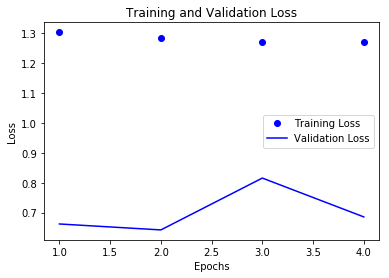

In [58]:
# Plot training and validation loss 
# Code provided by Chollet (2018, p. 74)

import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'bo', label='Training Loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

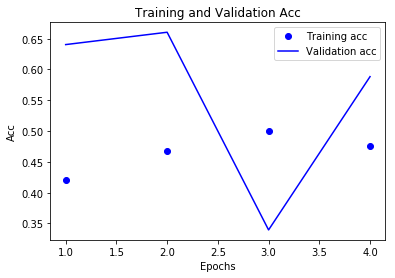

In [59]:
# Plot training and validation accuracy 
# Code provided by Chollet (2018, p. 75)

plt.clf()
acc = history_dict['acc']
val_acc = history_dict['val_acc']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation Acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [51]:
# View the probability produced of each test record
# Code provided by Jason Brownlee (2019) in 'How to Calculate Precision, Recall, F1, and More for Deep Learning Models’

yhat_prob = model.predict(X_test)

In [52]:
# Code provided by Jason Brownlee (2019) in 'How to Calculate Precision, Recall, F1, and More for Deep Learning Models’

yhat_prob

array([[0.66120815],
       [0.5682653 ],
       [0.6478264 ],
       ...,
       [0.43197352],
       [0.63160396],
       [0.566455  ]], dtype=float32)

In [53]:
# Predict classes for test set
# Code provided by Jason Brownlee (2019) in 'How to Calculate Precision, Recall, F1, and More for Deep Learning Models’

yhat_classes = model.predict_classes(X_test)

In [54]:
# Calculate additional metrics 
# Code provided by Jason Brownlee (2019) in 'How to Calculate Precision, Recall, F1, and More for Deep Learning Models’

from sklearn import metrics
accuracy = metrics.accuracy_score(y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = metrics.precision_score(y_test, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = metrics.recall_score(y_test, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = metrics.f1_score(y_test, yhat_classes)
print('F1 score: %f' % f1)

Accuracy: 0.588366
Precision: 0.134718
Recall: 0.516710
F1 score: 0.213716


In [55]:
# Confusion matrix
# Code provided by Scikit-learn API Reference (2019) 

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, yhat_classes)

array([[1913, 1291],
       [ 188,  201]], dtype=int64)

In [56]:
# Code provided by Scikit-learn API Reference (2019) 

tn, fp, fn, tp = confusion_matrix(y_test, yhat_classes).ravel()
tn, fp, fn, tp

(1913, 1291, 188, 201)

In [57]:
# AUC
# Code provided by Scikit-learn API Reference (2019) 

fpr, tpr, thresholds = metrics.roc_curve(y_test, yhat_classes, pos_label=1)
metrics.auc(fpr, tpr)

0.5568878394295049